# 基于 dmc620 的实时内存带宽测量

`perf stat` 输出文件的路径

In [15]:
perf_raw_path = './dmc620.csv'

## 预处理

从 `perf stat` 输出的 CSV 文件中提取数据，形成数据表

- timestamp 时间戳，每秒一次
- event 事件名
- value 事件计数值

In [16]:
import pandas as pd
import numpy as np

perf_raw_data = pd.read_csv(perf_raw_path,
                            sep='|',
                            header=None, 
                            names=["timestamp", "value", "event"], 
                            usecols=[0, 1, 3])

perf_raw_data

,timestamp,value,event
0,1.001043,207485,"arm_dmc620_10008c000/clkdiv2_rdwr,mask=1,match=0/"
1,1.001043,212224,"arm_dmc620_10008c400/clkdiv2_rdwr,mask=1,match=0/"
2,1.001043,215099,"arm_dmc620_10008c800/clkdiv2_rdwr,mask=1,match=0/"
3,1.001043,207422,"arm_dmc620_10008cc00/clkdiv2_rdwr,mask=1,match=0/"
4,1.001043,201920,"arm_dmc620_10008d000/clkdiv2_rdwr,mask=1,match=0/"
...,...,...,...
17275,540.321962,122399,"arm_dmc620_50008cc00/clkdiv2_rdwr,mask=1,match=1/"
17276,540.321962,118217,"arm_dmc620_50008d000/clkdiv2_rdwr,mask=1,match=1/"
17277,540.321962,121097,"arm_dmc620_50008d400/clkdiv2_rdwr,mask=1,match=1/"
17278,540.321962,113599,"arm_dmc620_50008d800/clkdiv2_rdwr,mask=1,match=1/"


处理 event，从 event 中提取出：type 读写类型（read or write），device_id 即 dmc620 在 /sys/devices/ 的编号，socket 即 dmc620 设备所属的 socket

In [17]:
perf_raw_data['type'] = perf_raw_data['event'].apply(
    lambda x: 'read' if x[-2:-1] == '0' else 'write'
)
perf_raw_data['device_id'] = perf_raw_data['event'].apply(
    lambda x: x[11:20]
)
perf_raw_data['socket'] = perf_raw_data['device_id'].apply(
    lambda x: 0 if x[0] == '1' else '1'
)

perf_raw_data = perf_raw_data.drop('event', axis=1)
perf_raw_data

,timestamp,value,type,device_id,socket
0,1.001043,207485,read,10008c000,0
1,1.001043,212224,read,10008c400,0
2,1.001043,215099,read,10008c800,0
3,1.001043,207422,read,10008cc00,0
4,1.001043,201920,read,10008d000,0
...,...,...,...,...,...
17275,540.321962,122399,write,50008cc00,1
17276,540.321962,118217,write,50008d000,1
17277,540.321962,121097,write,50008d400,1
17278,540.321962,113599,write,50008d800,1


## 分析

系统整体带宽

对每个时间戳，聚合所有 device 的计数值，求和，乘以 64 再除以时间

【推测】这里一次 read 或 write 的数据量应该是 64 bits

In [18]:
bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

bw_all['interval'] = bw_all['timestamp'].diff()
bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)

bw_all

,timestamp,value,interval,memory bandwidth (GB/s)
0,1.001043,10015007,1.001043,0.640292
1,2.006591,6860210,1.005547,0.436631
2,3.007889,3788860,1.001298,0.242173
3,4.009507,7298158,1.001618,0.466327
4,5.010948,6984929,1.001441,0.446392
...,...,...,...,...
535,536.850778,10841753,1.002598,0.692074
536,537.852104,7516932,1.001326,0.480447
537,538.853738,10226524,1.001634,0.653430
538,539.856127,3207076,1.002390,0.204764


单个 dmc620 内存带宽上限

3200 Mbps -- bits per second

3200 Mbps = 400 * 10^6 Byte per second = 381.47 MiB/s

整机 2 socket 共计 16 个 dmc620，合计最大带宽 6103.52 MiB/s

【和先前在 Ampere 上 STREAM 的测试结果差不多】

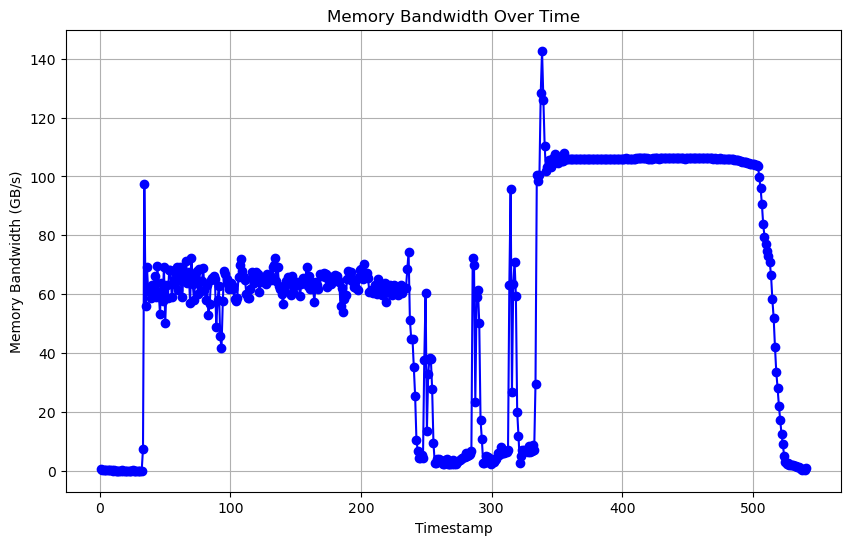

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
plt.title('Memory Bandwidth Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Memory Bandwidth (GB/s)')
plt.grid(True)
plt.show()